In [1]:
%cd /home/dongmin/23FW-NCG/jeongganbo-omr
%load_ext autoreload
%autoreload 2

/home/dongmin/userdata/jeongganbo-omr


In [2]:
!nvidia-smi

Fri Jun 28 15:36:41 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:01:00.0 Off |                  Off |
| 30%   36C    P8    16W / 230W |      1MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:02:00.0 Off |                  Off |
| 30%   

In [3]:
from time import time
import csv
import re
import glob
import json
from random import randint, choice, uniform, seed
from collections import defaultdict, Counter
import pickle
from pathlib import Path

from tqdm import tqdm
import matplotlib.pyplot as plt

from omegaconf import OmegaConf

import numpy as np
import torch
from torch.utils.data import DataLoader

from exp_utils.model_zoo import TransformerOMR
from exp_utils.train_utils import Trainer, Tokenizer, pad_collate, LabelStudioDataset

from test_er import make_gt_pred_tuple_list
import Levenshtein

dprint = lambda d: print(json.dumps(d, indent=2))

/home/dongmin/.local/share/virtualenvs/jeongganbo-omr-QQMBMPoZ/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Edit distance test

### inference fn

In [15]:
def calc_ed(project_root_dir, exp_dir):
  conf = OmegaConf.load(exp_dir / '.hydra' / 'config.yaml')
  device = torch.device(conf.general.device)

  model_dir = exp_dir / 'model'

  print('\nload tokenizer')

  tokenizer_vocab_fn = model_dir / f'{conf.general.model_name}_tokenizer.txt'
  tokenizer = Tokenizer(vocab_txt_fn=tokenizer_vocab_fn)

  print('COMPLETE: load tokenizer')


  print('\ndata_set loading...')

  test_set = LabelStudioDataset(project_root_dir / conf.data_path.test, project_root_dir / 'jeongganbo-png/splited-pngs', remove_borders=conf.test_setting.remove_borders, is_valid=True)

  test_set.tokenizer = tokenizer

  test_loader = DataLoader(test_set, batch_size=1000, shuffle=False, collate_fn=pad_collate, num_workers=conf.dataloader.num_workers_load)

  print('COMPLETE: data_set loading')


  print('\nmodel initializing...')
  model = TransformerOMR(conf.model.dim, len(tokenizer.vocab), enc_depth=conf.model.enc_depth, dec_depth=conf.model.dec_depth, num_heads=conf.model.num_heads, dropout=conf.model.dropout)
  model.load_state_dict(torch.load(model_dir / f'{conf.general.model_name}_HL_{conf.test_setting.target_metric}_best.pt', map_location='cpu')['model'])

  tester = Trainer(model, 
                  None, #optimizer
                  None, #loss_fn
                  None, #train_loader
                  test_loader, 
                  tokenizer,
                  device=device, 
                  scheduler=None,
                  aux_loader=None,
                  aux_freq=None,
                  mix_aux=None,
                  aux_valid_loader=None,
                  wandb=None, 
                  model_name=conf.general.model_name,
                  model_save_path=model_dir,
                  checkpoint_logger=None)

  print('COMPLETE: model initializing')


  print('\nTesting...')

  _, metric_dict, pred_tensor_list, _ = tester.validate(with_confidence=True)

  print('COMPELETE: Testing')
  
  pred_list = []

  for b_idx in range(len(pred_tensor_list)):
    pred_list += pred_tensor_list[b_idx].tolist()

  pred_list = list( enumerate(pred_list) )
  pred_list = make_gt_pred_tuple_list(test_set, tokenizer, pred_list) 
  
  dists = []
  dist_ratios = []
  
  for case in pred_list:
    label, pred = case[2:4]
    
    ed = Levenshtein.distance(pred, label)
    
    dists.append(ed)
    dist_ratios.append(round(ed / len(label), 2))
  
  sorted_dists = sorted([ tup for tup in dict(Counter(dists)).items() ], key=lambda x: x[0])
  sorted_ratios = sorted([ tup for tup in dict(Counter(dist_ratios)).items() ], key=lambda x: x[0])
  
  return metric_dict, len(pred_list), sorted_dists, sorted_ratios

### process test result

In [16]:
dir_date = '2024-05-04'
dir_times = [
  '09-35-37', 
  '10-22-54', 
  '15-50-51', 
]

project_root_dir = Path('.')
output_dir = project_root_dir / 'outputs'

sorted_dists_ls = []

for dir_time in dir_times:
  exp_dir = output_dir / dir_date / dir_time  
  _, num_cases, sorted_dists, _ = calc_ed(project_root_dir, exp_dir)
  
  sorted_dists_ls.append( (num_cases, sorted_dists) )


load tokenizer
COMPLETE: load tokenizer

data_set loading...
COMPLETE: data_set loading

model initializing...
COMPLETE: model initializing

Testing...


COMPELETE: Testing

load tokenizer
COMPLETE: load tokenizer

data_set loading...
COMPLETE: data_set loading

model initializing...
COMPLETE: model initializing

Testing...


COMPELETE: Testing

load tokenizer
COMPLETE: load tokenizer

data_set loading...
COMPLETE: data_set loading

model initializing...
COMPLETE: model initializing

Testing...


COMPELETE: Testing


## draw accumulative plot

In [31]:
max_dist = []

data = []

for num_cases, sorted_dists in sorted_dists_ls:
  num_ops = [ tup[0] for tup in sorted_dists ]

  num_ex = [ tup[1] for tup in sorted_dists ]

  num_ex_cumsum = np.cumsum(num_ex) / num_cases
  
  max_dist.append(max(num_ops))
  data.append(list(zip(num_ops, num_ex_cumsum)))

  print(sorted_dists, num_ex_cumsum, num_ex)

max_dist = max(max_dist)

[(0, 1272), (1, 162), (2, 49), (3, 10), (4, 23), (5, 8), (6, 5), (7, 1), (8, 1), (10, 1)] [0.83028721 0.93603133 0.96801567 0.97454308 0.98955614 0.99477807
 0.99804178 0.99869452 0.99934726 1.        ] [1272, 162, 49, 10, 23, 8, 5, 1, 1, 1]
[(0, 1318), (1, 131), (2, 38), (3, 7), (4, 24), (5, 7), (6, 4), (7, 1), (8, 1), (12, 1)] [0.86031332 0.94582245 0.97062663 0.97519582 0.99086162 0.99543081
 0.99804178 0.99869452 0.99934726 1.        ] [1318, 131, 38, 7, 24, 7, 4, 1, 1, 1]
[(0, 1394), (1, 72), (2, 29), (3, 2), (4, 23), (5, 8), (6, 3), (10, 1)] [0.90992167 0.95691906 0.97584856 0.97715405 0.9921671  0.99738903
 0.99934726 1.        ] [1394, 72, 29, 2, 23, 8, 3, 1]


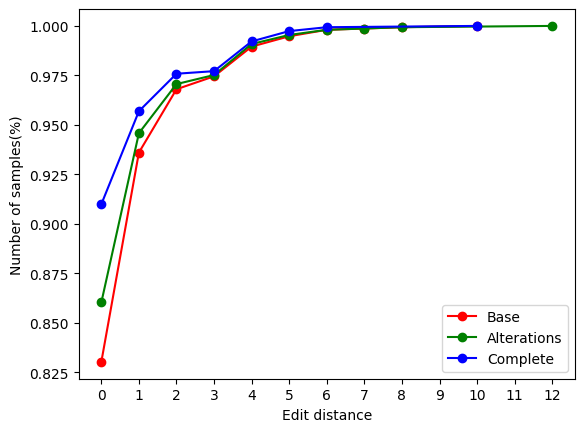

In [42]:
settings = [('r', 'Base'), ('g', 'Alterations'), ('b', 'Complete')]

plt.xticks(np.arange(max_dist+1))
plt.xlabel('Edit distance')
plt.ylabel('Number of samples(%)')

for i, d in enumerate(data):
  plt.plot([p[0] for p in d], [p[1] for p in d], settings[i][0]+'o-', label=settings[i][1] )

plt.legend()